# AEWS Python Notebook 08f: AEWS miscellanea

**Author**: Eric Lehmann, CSIRO Data61  
**Date**:  July 07, 2016

**Note**: The Python code below is "rudimentary" etc. etc. Priority is here given to code interpretability rather than execution efficiency.

**Note**: this notebook should be accessible and viewable at [https://github.com/eric542/agdc_v2/tree/master/notebooks](https://github.com/eric542/agdc_v2/tree/master/notebooks).

## Summary

Building up on the concepts introduced in the previous notebooks in this series, we work out the remaining components of the AEWS implementation &mdash; see *'AEWS Python Notebook 08a'* for details of these components. The contents summary for the present notebook is given below.

**Abstract** &mdash; One aspect of the AWES is related to dealing with latest available Landsat imagery. The AGDC API does not currently provide a mechanism to produce alerts when new Landsat data is made available for a given ROI. So, code will need to be written, e.g., for the following purposes:

1. process the existing AGDC database for waterbodies of interest
2. check for availability of new Landsat imagery at regular intervals (at most daily)
3. processing of new imagery to produce water quality (turbidity) data, and append to existing WQ time series.

The present notebook (08e) investigates some of these concepts. In the following, it will be assumed that the WQ data is saved as `.netCDF` dataset that includes a time series of WQ maps (in contrast to saving only the latest available map).


## Preliminaries

This (Jupyter) notebook was written for use on the NCI's VDI system, with the following pre-loaded module:

```
 $ module use /g/data/v10/public/modules/modulefiles --append
 $ module load agdc-py2-prod 
```

**NOTE**: the specific module loaded here (`agdc-py2-prod`) is different from the module loaded in earlier notebooks (`agdc-py2-dev`)! While the earlier module contained only Landsat 5 data, the `agdc-py2-prod` module links to a (different) AGDC database containing the following NBART/NBAR/PQA datasets:

* Landsat 8: 2013
* Landsat 7: 2013
* Landsat 5: 2006/2007

It is unclear whether the API functions in these 2 modules are identical or represent different versions.

**NOTE 2**: as of mid-June 2016, changes were made to the AGDC API v2.0, and the above Landsat datasets (and related API functions) can now be accessed through the module `agdc-py2-prod/1.0.3` (pre-major-change version). How long this module will remain accessible and/or when it will be replaced with the formal v2.0 API is still unclear at this time (June 2016).

In [1]:
%%html  # Definitions for some pretty text boxes...
<style>
    div.warn { background-color: #e8c9c9; border: 1px solid #c27070; border-left: 6px solid #c27070; padding: 0.5em }
    div.note { background-color: #cce0ff; border: 1px solid #5c85d6; border-left: 6px solid #5c85d6; padding: 0.5em }
    div.info { background-color: #ffe680; border: 1px solid #cca300; border-left: 6px solid #cca300; padding: 0.5em }
</style>

In [2]:
%matplotlib inline
import matplotlib.image as img
import matplotlib.pyplot as plt
import numpy as np

import json
import ogr, gdal, osr
import xarray
from netCDF4 import Dataset, num2date, date2num
from datetime import date, timedelta, datetime

from pylab import rcParams
rcParams['figure.figsize'] = (10,10)   # increase plot size a bit...
rcParams['axes.formatter.useoffset'] = False   # disable scalar formatter / offset in axes labels

from pprint import pprint
from __future__ import print_function

import datacube.api   # import the AGDC v2 API, with pre-loaded 'agds-py2-dev' (or similar) NCI module
from datacube.analytics.analytics_engine import AnalyticsEngine
from datacube.execution.execution_engine import ExecutionEngine

def scale_array(arr, prcnt, min_val, max_val, nan_val):
    # Function: Linearly scales array 'arr' at the 'prcnt' percentile between 'min_val'
    # and 'max_val', replacing 'nan_val' values with NumPy NaN's.
    f_arr = arr.astype('float') # required for NaN's
    if not np.isnan(nan_val): f_arr[f_arr==nan_val] = np.nan
    prcnt_delta = (100-prcnt)/2
    clip_lim = np.nanpercentile(f_arr,(prcnt_delta,100-prcnt_delta))
    f_arr = np.clip(f_arr,clip_lim[0],clip_lim[1])
    f_arr = (f_arr-clip_lim[0]) / (clip_lim[1]-clip_lim[0])
    f_arr = f_arr * (max_val-min_val) + min_val
    return f_arr

def merge_dup_dates(xada):
    # Takes in an xarray.DataArray 'xada' as input and merges 
    # datasets (time slices) within it that have the same dates.
    # Returns the modified DataArray and vector of selected dates.
    dates = xada.coords['time'].values
    n_dates = len( dates )
    
    # Convert UTM times to local dates (d/m/y only):
    str_dates = np.zeros(n_dates).astype('str')
    for ii in range(n_dates):
        str_dates[ii] = str( dates[ii] )[:10]
    
    # Remove duplicated dates:
    rem_ind = np.zeros(n_dates).astype('bool')   # keep track of which duplicated dates to remove
    for ind in range(1,n_dates):
        dup_ind = np.where( str_dates[:ind]==str_dates[ind] )[0]   # check for duplicated date up to current index
        if len( dup_ind )!=0:   # found (at least) one duplicate
            dup_ind = dup_ind[0]   # only use the first index if multiple dates returned
            rem_ind[ind] = True    # remove current date index
            ind_n_nans = np.sum( np.isnan( xada[ind] ) ) # nr of NaN pixels in each image
            dup_n_nans = np.sum( np.isnan( xada[dup_ind] ) )
            if ind_n_nans==0:     # current data has no NaN's, use it instead of duplicate date (copy it to lowest index)
                xada[dup_ind] = xada[ind]
            elif dup_n_nans!=0:   # if duplicate date has no NaN's: do nothing (use it instead of current date)
                if dup_n_nans<ind_n_nans:   # duplicate date has less NaN's: fill it in with current data
                    tmp = np.where( np.isnan(xada[dup_ind]) )
                    xada[dup_ind].values[tmp] = xada[ind].values[tmp]
                else:   # dup_n_nans>=ind_n_nans -- duplicate date has more NaN's: use it to fill in current data
                    tmp = np.where( np.isnan(xada[ind]) )
                    xada[ind].values[tmp] = xada[dup_ind].values[tmp]
                    xada[dup_ind] = xada[ind]   # save results to lowest date index, in case >2 slices have same date
    
    return xada[~rem_ind]

## Creating a basic netCDF dataset

Let's create a basic dataset of WQ data for all available dates but the latest date. We'll used here the same example ROI as in a previous notebook.

In [3]:
lakes_file = '../NSW_lakes/NSW_WaterBody.shp'
lakes_vec = ogr.Open(lakes_file)
lakes_lyr = lakes_vec.GetLayer(0)

n_ftr = lakes_lyr.GetFeatureCount()
lname_list = list()
for kk in range( n_ftr ):
    ftr = lakes_lyr.GetFeature(kk)
    lname_list.append(ftr.GetField('hydroname'))

ftr = lname_list.index('WONGALARA')
lakes_ftr = lakes_lyr.GetFeature(ftr)
ring = lakes_ftr.GetGeometryRef().GetGeometryRef(0)
poly_array = np.array(ring.GetPoints())[:,0:2]  # lon / lat coords of polygon

In [4]:
dc = datacube.api.API()

In [5]:
dimensions = { 'lon' : { 'range': ( min(poly_array[:,0])-0.02, max(poly_array[:,0])+0.02 ) },
               'lat' : { 'range': ( max(poly_array[:,1])+0.02, min(poly_array[:,1])-0.02 ) } }
query = { 'product': 'nbar',
          'platform': 'LANDSAT_8',
          'dimensions': dimensions }
desc = dc.get_descriptor(query, include_storage_units=False)
print( "Nr. available dates:", desc['ls8_nbar_albers']['result_shape'][0])
print( "First date:", str( min( desc['ls8_nbar_albers']['irregular_indices']['time'] ) ) )
print( "Last date:", str( max( desc['ls8_nbar_albers']['irregular_indices']['time'] ) ) )

Nr. available dates: 112
First date: 2013-03-26T00:09:17.140271000
Last date: 2013-12-27T00:16:03.431356000


So we can see that for the considered ROI, there are 112 time slices up to and including 2013-12-27. We will create the WQ dataset for all time slices up to (but excluding) that date.

In [6]:
dimensions = { 'lon' : { 'range': ( min(poly_array[:,0])-0.02, max(poly_array[:,0])+0.02 ) },
               'lat' : { 'range': ( max(poly_array[:,1])+0.02, min(poly_array[:,1])-0.02 ) },
               'time': { 'range': ((2013, 3, 26), (2013, 12, 27)) } }

query = { 'product': 'nbar',
          'platform': 'LANDSAT_8',
          'dimensions': dimensions }
desc = dc.get_descriptor(query, include_storage_units=False)
print( "Nr. available dates:", desc['ls8_nbar_albers']['result_shape'][0])
print( "First date:", str( min( desc['ls8_nbar_albers']['irregular_indices']['time'] ) ) )
print( "Last date:", str( max( desc['ls8_nbar_albers']['irregular_indices']['time'] ) ) )

Nr. available dates: 109
First date: 2013-03-26T00:09:17.140271000
Last date: 2013-12-20T00:09:54.117418000


We have now only 109 time slices, not including 2013-12-27 &mdash; the 3 remaining slices have a 2013-12-27 date tag.

In passing, this exercise also highlights the following important feature.
<br><br>
<div class=note>
<b>NOTE:</b> when quering the database, the start date of the selected time window is included in the search, while the end date is not.
</div>

We can now create the (partial) database as per usual... However, as per the example in *'AEWS Python Notebook 08c'*, we know that the LS8 dataset over the ROI is missing a date of PQ data for 2013-10-01. We will thus only use the data from that date onwards.

In [7]:
dimensions = { 'lon' : { 'range': ( min(poly_array[:,0])-0.02, max(poly_array[:,0])+0.02 ) },
               'lat' : { 'range': ( max(poly_array[:,1])+0.02, min(poly_array[:,1])-0.02 ) },
               'time': { 'range': ((2013, 10, 2), (2013, 12, 27)) } }

query = { 'product': 'nbar',
          'platform': 'LANDSAT_8',
          'dimensions': dimensions }
desc = dc.get_descriptor(query, include_storage_units=False)
print( "Nr. available NBAR dates:", desc['ls8_nbar_albers']['result_shape'][0])

PQquery = { 'product': 'pqa',
            'platform': 'LANDSAT_8',
            'dimensions': dimensions }
desc = dc.get_descriptor(PQquery, include_storage_units=False)
print( "Nr. available PQ dates:", desc['ls8_pq_albers']['result_shape'][0])

Nr. available NBAR dates: 32
Nr. available PQ dates: 32


We now have the same number of NBAR and PQ time slices, so we can now create our test database.

As a side note of potential interest, it can be seen that for some time slices, the PQ masks sometimes appear to not correspond to the NBAR data:

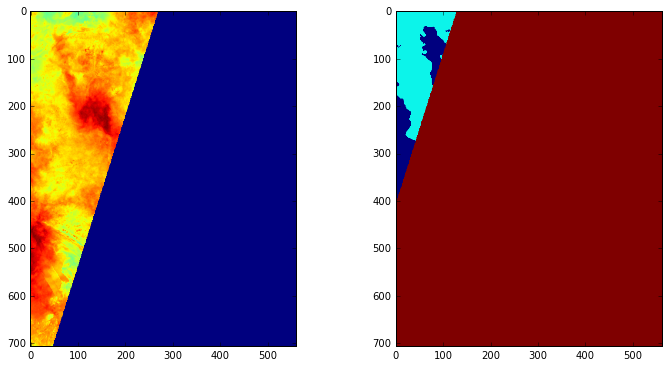

In [8]:
nbar_data = dc.get_data( query )
pq_data = dc.get_data( PQquery )

idx = 15   # 1, 8

plt.figure( figsize=(12,6) )
plt.subplot( 1,2,1 )
plt.imshow( nbar_data['arrays']['band_3'][idx].values )

plt.subplot( 1,2,2 )
plt.imshow( pq_data['arrays']['pixelquality'][idx].values );

This is the result of the LS bands being slightly offset relative to each other. The PQ layer only has data where all the bands overlap (possibly because all bands are required to derive PQ information).

Let's now create our WQ database...

In [9]:
ae = AnalyticsEngine()
ee = ExecutionEngine()

aeB2 = ae.create_array(('LANDSAT_8', 'nbar'), ['band_3'], dimensions, 'aeB2')
aeB3 = ae.create_array(('LANDSAT_8', 'nbar'), ['band_4'], dimensions, 'aeB3')
aeB4 = ae.create_array(('LANDSAT_8', 'nbar'), ['band_5'], dimensions, 'aeB4')
aeB5 = ae.create_array(('LANDSAT_8', 'nbar'), ['band_6'], dimensions, 'aeB5')
aePQ = ae.create_array(('LANDSAT_8', 'pqa'), ['pixelquality'], dimensions, 'aePQ')
aeWQ = ae.apply_expression([aeB2, aeB3], '((array1 + array2) * 0.5)', 'aeWQ')
aeWQ_PQmsk = ae.apply_expression([aeWQ, aePQ], 'array1{array2}', 'aeWQ_PQmsk')
ee.execute_plan(ae.plan)

INFO:datacube.analytics.analytics_engine:Initialise Analytics Module.
INFO:datacube.execution.execution_engine:Initialise Execution Module.


In [10]:
# Merge datasets with duplicated dates:
B2_xarray = ee.cache['aeB2']['array_result'].values()[0]
B2_xarray = merge_dup_dates( B2_xarray.load() )
B3_xarray = ee.cache['aeB3']['array_result'].values()[0]
B3_xarray = merge_dup_dates( B3_xarray.load() )
B4_xarray = ee.cache['aeB4']['array_result'].values()[0]
B4_xarray = merge_dup_dates( B4_xarray.load() )
B5_xarray = ee.cache['aeB5']['array_result'].values()[0]
B5_xarray = merge_dup_dates( B5_xarray.load() )
WQ_xarray = ee.cache['aeWQ']['array_result']['aeWQ']
WQ_xarray = merge_dup_dates( WQ_xarray.load() )
WQ_pqm_xarray = ee.cache['aeWQ_PQmsk']['array_result']['aeWQ_PQmsk']
WQ_pqm_xarray = merge_dup_dates( WQ_pqm_xarray.load() )

In [11]:
# remove empty time slices:
tmp = np.where( ( (~np.isnan(B2_xarray)).sum('x').sum('y')!=0 ).values )[0] 
B2_xarray = B2_xarray[tmp]
tmp = np.where( ( (~np.isnan(B3_xarray)).sum('x').sum('y')!=0 ).values )[0]
B3_xarray = B3_xarray[tmp]
tmp = np.where( ( (~np.isnan(B4_xarray)).sum('x').sum('y')!=0 ).values )[0]
B4_xarray = B4_xarray[tmp]
tmp = np.where( ( (~np.isnan(B5_xarray)).sum('x').sum('y')!=0 ).values )[0]
B5_xarray = B5_xarray[tmp]
tmp = np.where( ( (~np.isnan(WQ_xarray)).sum('x').sum('y')!=0 ).values )[0]
WQ_xarray = WQ_xarray[tmp]
tmp = np.where( ( (~np.isnan(WQ_pqm_xarray)).sum('x').sum('y')!=0 ).values )[0]
WQ_pqm_xarray = WQ_pqm_xarray[tmp]   # more dates could need removing due to cloud masking

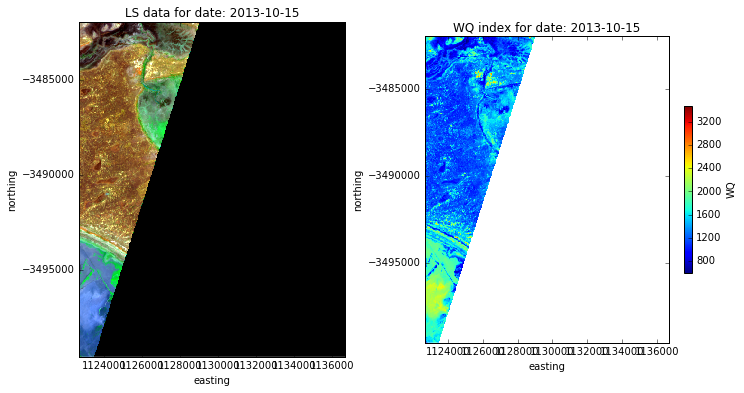

In [12]:
# plot some data to check results:
date_ind = 0   # selected date index
sB2data = scale_array(B2_xarray[date_ind].values, 99.0, 0, 255, np.nan)
sB4data = scale_array(B4_xarray[date_ind].values, 99.0, 0, 255, np.nan)
sB5data = scale_array(B5_xarray[date_ind].values, 99.0, 0, 255, np.nan)
FC_image = np.zeros((B2_xarray.shape[1], B2_xarray.shape[2], 3), dtype='uint8')
FC_image[:,:,0] = sB5data; FC_image[:,:,1] = sB4data; FC_image[:,:,2] = sB2data

xvec = B2_xarray.coords['x']; yvec = B2_xarray.coords['y']

plt.figure( figsize=(12,6) ); plt.subplot( 1,2,1 )
plt.imshow(FC_image, interpolation='none', extent=[xvec[0],xvec[-1],yvec[-1],yvec[0]], aspect=1)
plt.title( 'LS data for date: {}'.format(str(B2_xarray.coords['time'][date_ind].values)[:10]) )
plt.ylabel('northing'); plt.xlabel('easting');

plt.subplot( 1,2,2 )
plt.imshow( WQ_xarray[date_ind], interpolation='none', extent=[xvec[0],xvec[-1],yvec[-1],yvec[0]], aspect=1)
plt.title( 'WQ index for date: {}'.format(str(WQ_xarray.coords['time'][date_ind].values)[:10]) )
plt.ylabel('northing'); plt.xlabel('easting')
plt.colorbar(orientation='vertical', shrink=0.5, label='WQ');

Some analysis of available dates for this dataset...

In [13]:
WQ_xarray['time'].values   # dates resulting from pre-processing

array(['2013-10-15T00:21:51.933886000', '2013-10-24T00:15:35.802926000',
       '2013-10-31T00:21:43.656236000', '2013-11-09T00:15:33.871688000',
       '2013-11-16T00:21:41.619527000', '2013-11-25T00:15:31.771429000',
       '2013-12-02T00:21:37.566433000', '2013-12-11T00:15:24.714468000',
       '2013-12-18T00:21:29.631279000'], dtype='datetime64[ns]')

In [14]:
ee.cache['aeWQ']['array_indices']['time']   # all dates in the dataset

array(['2013-10-15T00:21:51.933886000', '2013-10-15T00:22:15.879350000',
       '2013-10-17T00:09:53.424217000', '2013-10-17T00:10:17.375719000',
       '2013-10-24T00:15:35.802926000', '2013-10-24T00:15:59.754732000',
       '2013-10-24T00:16:23.700161000', '2013-10-31T00:21:43.656236000',
       '2013-10-31T00:22:07.603098000', '2013-11-02T00:09:46.645182000',
       '2013-11-02T00:10:10.592552000', '2013-11-09T00:15:33.871688000',
       '2013-11-09T00:15:57.822843000', '2013-11-09T00:16:21.768350000',
       '2013-11-16T00:21:41.619527000', '2013-11-16T00:22:05.567043000',
       '2013-11-18T00:09:42.308185000', '2013-11-18T00:10:06.265899000',
       '2013-11-25T00:15:31.771429000', '2013-11-25T00:15:49.217516000',
       '2013-11-25T00:16:13.171365000', '2013-12-02T00:21:37.566433000',
       '2013-12-02T00:22:01.511915000', '2013-12-04T00:09:46.530853000',
       '2013-12-04T00:10:03.841456000', '2013-12-11T00:15:24.714468000',
       '2013-12-11T00:15:48.663264000', '2013-12-11

Note that, contrary to the example dataset used in _'AEWS Python Notebook 06'_, the dates here appear to be provided without time zone information, and are thus likely given in UTC+0000 format (?).  
<br>
<div class=warn>
<b>TO DO:</b> with the final dataset, we will need to work out the exact format of the provided 'time' variable, and how to convert it to local time. The solution might be to use GA's _solar day_ approach.
</div>

The `numpy` module also seems to have been updated since that earlier notebook, with a warning that time zone information is now deprecated:

In [15]:
np.datetime64('2013-10-15T00:21:51.933886000+0000')

/g/data2/v10/public/modules/agdc-py2-env/anaconda2-2.5.0/envs/agdc/lib/python2.7/site-packages/ipykernel/__main__.py:1: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  if __name__ == '__main__':


numpy.datetime64('2013-10-15T00:21:51.933886000')

For now, we will simply use some simplistic (though potentially erroneous) date/time information, for testing purposes...

In [16]:
# Extracting Y/M/D dates in datetime format:
LS_dates = WQ_xarray['time'].values
n_dates = len( LS_dates )
dt_dates = np.zeros(n_dates).astype(datetime)
for ii in range(n_dates):
    tmp = str( LS_dates[ii] )
    dt_dates[ii] = datetime( int(tmp[0:4]), int(tmp[5:7]), int(tmp[8:10]), 
                             int(tmp[11:13]), int(tmp[14:16]), int(tmp[17:19]) )
dt_dates

array([datetime.datetime(2013, 10, 15, 0, 21, 51),
       datetime.datetime(2013, 10, 24, 0, 15, 35),
       datetime.datetime(2013, 10, 31, 0, 21, 43),
       datetime.datetime(2013, 11, 9, 0, 15, 33),
       datetime.datetime(2013, 11, 16, 0, 21, 41),
       datetime.datetime(2013, 11, 25, 0, 15, 31),
       datetime.datetime(2013, 12, 2, 0, 21, 37),
       datetime.datetime(2013, 12, 11, 0, 15, 24),
       datetime.datetime(2013, 12, 18, 0, 21, 29)], dtype=object)

As seen in the previous notebook (*AEWS Python Notebook 08e*), the 'time' dimension needs to be defined as 'unlimited' so as to allow subsequent data to be appended to the WQ netCDF database.

In [17]:
rootgrp = Dataset("test_WQ_data.nc", "w")   # overwrites any existing file

time = rootgrp.createDimension("time", None)   # unlimited dimension
x = rootgrp.createDimension("x", WQ_xarray['x'].shape[0])
y = rootgrp.createDimension("y", WQ_xarray['y'].shape[0])

time_vals = rootgrp.createVariable("time","f8",("time",))
x_vals = rootgrp.createVariable("x","f8",("x",))
y_vals = rootgrp.createVariable("y","f8",("y",))
wq_vals = rootgrp.createVariable("test_WQ_data","f8",("time","y","x",), zlib=True)

time_vals.units = "seconds since 1970-01-01 00:00:00.0"
time_vals.calendar = "standard"

x_vals[:] = WQ_xarray['x'].values
y_vals[:] = WQ_xarray['y'].values
wq_vals[:,:,:] = WQ_xarray.values
time_vals[:] = date2num(dt_dates, units=time_vals.units, calendar=time_vals.calendar )

rootgrp.close()
!ls -lh test_WQ_data.nc

-rw-r--r-- 1 eal599 jr4 6.8M Jul  6 09:10 test_WQ_data.nc


In [18]:
print( "The WQ dataset has a total of", WQ_xarray.shape[0], "dates." )
print( "Last date in the dataset:", str(WQ_xarray.coords['time'][-1].values)[:10] )

The WQ dataset has a total of 9 dates.
Last date in the dataset: 2013-12-18


## Loading the netCDF dataset & checking for new imagery

Now that we have a test netCDF dataset, let's see how we can load it and determine the existing dates.

In [19]:
nc_grp = Dataset("test_WQ_data.nc", mode='r')
print( nc_grp )

<type 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): time(9), x(561), y(706)
    variables(dimensions): float64 time(time), float64 x(x), float64 y(y), float64 test_WQ_data(time,y,x)
    groups: 



In [20]:
nc_grp.variables.keys()

[u'time', u'x', u'y', u'test_WQ_data']

In [21]:
# Retrieve dates:
nc_dates = nc_grp.variables['time']
print( nc_dates )
print( nc_dates[:] )

<type 'netCDF4._netCDF4.Variable'>
float64 time(time)
    units: seconds since 1970-01-01 00:00:00.0
    calendar: standard
unlimited dimensions: time
current shape = (9,)
filling on, default _FillValue of 9.96920996839e+36 used

[  1.38179651e+09   1.38257374e+09   1.38317890e+09   1.38395613e+09
   1.38456130e+09   1.38533853e+09   1.38594370e+09   1.38672092e+09
   1.38732609e+09]


So we can access the existing dates of the netCDF dataset as shown above, but by default, these are given in seconds/minutes/hours/etc. since a given date, as defined when saving them. We can transfer these dates to a more suitable format as follows...

In [22]:
nc_units = nc_grp.variables['time'].units
nc_cal = nc_grp.variables['time'].calendar
dates = num2date(nc_dates[:], nc_units, calendar=nc_cal)
dates

array([datetime.datetime(2013, 10, 15, 0, 21, 51),
       datetime.datetime(2013, 10, 24, 0, 15, 35),
       datetime.datetime(2013, 10, 31, 0, 21, 43),
       datetime.datetime(2013, 11, 9, 0, 15, 33),
       datetime.datetime(2013, 11, 16, 0, 21, 41),
       datetime.datetime(2013, 11, 25, 0, 15, 31),
       datetime.datetime(2013, 12, 2, 0, 21, 37),
       datetime.datetime(2013, 12, 11, 0, 15, 24),
       datetime.datetime(2013, 12, 18, 0, 21, 29)], dtype=object)

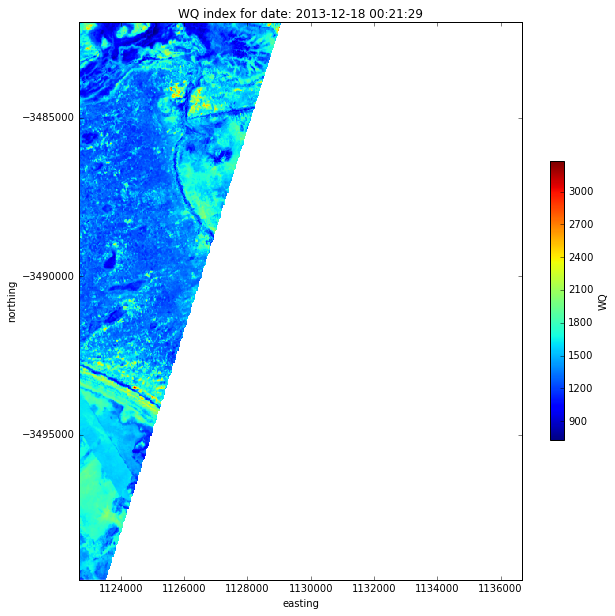

In [23]:
# Retrieve WQ data:
xvec = nc_grp.variables['x'][:]
yvec = nc_grp.variables['y'][:]
plt.imshow(nc_grp.variables['test_WQ_data'][-1,:,:], 
           interpolation='none', extent=[xvec[0],xvec[-1],yvec[-1],yvec[0]], aspect=1)
plt.title( 'WQ index for date: {}'.format(dates[-1]) )
plt.ylabel('northing'); plt.xlabel('easting')
plt.colorbar(orientation='vertical', shrink=0.5, label='WQ');

In [24]:
nc_grp.close()

So `dates[-1]` provides the latest date in the existing dataset. Now, to check the AGDC database for any new available data since that date, we can work out the date range of our next query as follows. The start date will be one day following the existing date, and the end date is one day following today (so as to include today in the search):

In [25]:
sdd = dates[-1] + timedelta(days=1)   # start date
edd = date.today() + timedelta(days=1)   # end date

The new AGDC query would thus be:

In [26]:
dimensions['time'] = { 'range': ( (sdd.year,sdd.month,sdd.day), (edd.year,edd.month,edd.day) ) }
query['dimensions'] = dimensions
pprint(query)

{'dimensions': {'lat': {'range': (-31.481184481999929, -31.629036433999961)},
                'lon': {'range': (143.96363326100001, 144.09656539400012)},
                'time': {'range': ((2013, 12, 19), (2016, 7, 7))}},
 'platform': 'LANDSAT_8',
 'product': 'nbar'}


In [27]:
desc = dc.get_descriptor(query, include_storage_units=False)
print( "Nr. available dates:", desc['ls8_nbar_albers']['result_shape'][0])
print( "First date:", str( min( desc['ls8_nbar_albers']['irregular_indices']['time'] ) ) )
print( "Last date:", str( max( desc['ls8_nbar_albers']['irregular_indices']['time'] ) ) )

Nr. available dates: 5
First date: 2013-12-20T00:09:30.166874000
Last date: 2013-12-27T00:16:03.431356000


This returns the latest time slices in the AGDC database. It also returns a time slice for 2013-12-20, which was actually part of the original time window of the existing dataset. This time slice likely does not contain any valid data, and has thus been discarded when creating the existing netCDF file. If we are to further process the latest available imagery, this time slice would of course also be discarded (leading to some duplicate computational effort). 

In practice, a better solution may be to define the starting date as the creation date of the existing dataset (which can be saved as attribute of the netCDF dataset); this would then not return previously processed dates. HOWEVER: following a dataset's creation date, a Landsat epoch may be added with a date tag preceeding that creation date, in which case, a new query starting from the creation date would miss that epoch! The above code thus represents the best solution in this case.

## Updating the netCDF dataset

Once new imagery has been processed, it can be added to the existing netCDF dataset. Here, we'll use 'Method 2' from _'AEWS Python Notebook 08e'_ (i.e. save a second `.nc` file to disk and merge with previous dataset using command line function `ncrcat` from the `nco` NCI module), as this approach allows both datasets to be kept separate if needed, and also, this avoids the (potential) need to load the existing dataset into memory.

The second dataset should obviously be produced on the basis of the new imagery, as done above. To simplify things a bit, we'll use some dummy data here instead...

In [28]:
# some dummy data...
X = np.linspace(-2, .8, WQ_xarray['x'].shape[0])
Y = np.linspace(-1.5,  1.5, WQ_xarray['y'].shape[0])
Z = np.zeros((len(Y), len(X)))
for iy, y in enumerate(Y):
    for ix, x in enumerate(X):
        a = x + 1j * y
        z = 0
        Z[iy,ix] = np.nan
        for n in range(1, 50):
            z = z**2 + a
            if abs(z) > 2: 
                Z[iy,ix] = n
                break

In [29]:
new_WQ_xarray = WQ_xarray[0]   # 'recycle' WQ_xarray object...
new_WQ_xarray.values = Z

In [30]:
# Create the new .nc dataset:
rootgrp = Dataset("test_WQ_data_2.nc", "w")

time = rootgrp.createDimension("time", None)   # unlimited dimension
x = rootgrp.createDimension("x", new_WQ_xarray['x'].shape[0])
y = rootgrp.createDimension("y", new_WQ_xarray['y'].shape[0])

time_vals = rootgrp.createVariable("time","f8",("time",))
x_vals = rootgrp.createVariable("x","f8",("x",))
y_vals = rootgrp.createVariable("y","f8",("y",))
wq_vals = rootgrp.createVariable("test_WQ_data","f8",("time","y","x",), zlib=True)

time_vals.units = "seconds since 1970-01-01 00:00:00.0"
time_vals.calendar = "standard"

x_vals[:] = new_WQ_xarray['x'].values
y_vals[:] = new_WQ_xarray['y'].values
wq_vals[0,:,:] = new_WQ_xarray.values

# new date in the dataset:
tmp = str( max( desc['ls8_nbar_albers']['irregular_indices']['time'] ) )         
dt_date = datetime( int(tmp[0:4]), int(tmp[5:7]), int(tmp[8:10]), 
                    int(tmp[11:13]), int(tmp[14:16]), int(tmp[17:19]) )  
time_vals[:] = date2num(dt_date, units=time_vals.units, calendar=time_vals.calendar )

rootgrp.close()
!ls -lh test_WQ_data*.nc

-rw-r--r-- 1 eal599 jr4 4.1M Jul  6 09:10 test_WQ_data_2.nc
-rw-r--r-- 1 eal599 jr4 6.8M Jul  6 09:10 test_WQ_data.nc


In [31]:
# concatenating the .nc datasets
!ncrcat test_WQ_data.nc test_WQ_data_2.nc -O test_WQ_data_all.nc
!ls -lh test_WQ_data*.nc

-rw-r--r-- 1 eal599 jr4 4.1M Jul  6 09:10 test_WQ_data_2.nc
-rw-r--r-- 1 eal599 jr4 2.9M Jul  6 09:10 test_WQ_data_all.nc
-rw-r--r-- 1 eal599 jr4 6.8M Jul  6 09:10 test_WQ_data.nc


<div class=note>
<b>TO DO:</b> The final code will need to have a user-defined flag determining whether the new dataset replaces, or is appended to an existing dataset.
</div>

And now loading up the merged dataset to check the results. We should now have 10 dates, with the second last date being 2013-12-18 and last date 2013-12-27, with our dummy data appended to the end of the time series:

In [32]:
grp = Dataset("test_WQ_data_all.nc", "r")
print( grp['test_WQ_data'] )
print( grp['time'] )
time_var = grp['time']
dates = num2date(time_var[:], units=time_var.units, calendar=time_var.calendar)
print( dates )

<type 'netCDF4._netCDF4.Variable'>
float64 test_WQ_data(time, y, x)
unlimited dimensions: time
current shape = (10, 706, 561)
filling on, default _FillValue of 9.96920996839e+36 used

<type 'netCDF4._netCDF4.Variable'>
float64 time(time)
    units: seconds since 1970-01-01 00:00:00.0
    calendar: standard
unlimited dimensions: time
current shape = (10,)
filling on, default _FillValue of 9.96920996839e+36 used

[datetime.datetime(2013, 10, 15, 0, 21, 51)
 datetime.datetime(2013, 10, 24, 0, 15, 35)
 datetime.datetime(2013, 10, 31, 0, 21, 43)
 datetime.datetime(2013, 11, 9, 0, 15, 33)
 datetime.datetime(2013, 11, 16, 0, 21, 41)
 datetime.datetime(2013, 11, 25, 0, 15, 31)
 datetime.datetime(2013, 12, 2, 0, 21, 37)
 datetime.datetime(2013, 12, 11, 0, 15, 24)
 datetime.datetime(2013, 12, 18, 0, 21, 29)
 datetime.datetime(2013, 12, 27, 0, 16, 3)]


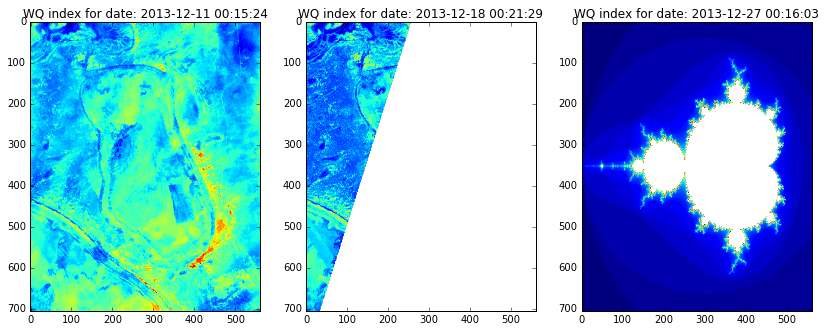

In [33]:
plt.figure( figsize=(14,6) )
plt.subplot( 1,3,1 )
plt.imshow( grp['test_WQ_data'][7,:,:] )
plt.title( 'WQ index for date: {}'.format(dates[7]) )

plt.subplot( 1,3,2 )
plt.imshow( grp['test_WQ_data'][8,:,:] )
plt.title( 'WQ index for date: {}'.format(dates[8]) )

plt.subplot( 1,3,3 )
plt.imshow(grp['test_WQ_data'][9,:,:] )
plt.title( 'WQ index for date: {}'.format(dates[9]) );

Seems like everything checks out... :)

In [34]:
grp.close()